# Risk assessment for flooding - building damage and population exposure

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FLOODS](https://github.com/CLIMAAX/FLOODS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Introduction
This workflow assesses economic damage to buildings, exposure of critical infrastructure, and population exposure & displacement, by combining flood map data (hazard) and population and building data (exposure).

<figure class="align-center">
  <iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/JWQbkcf75T4?si=CaBLEpgdI90EHOmE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</figure>

### Building damage & critical infrastructure
Flood risk in the form of economic damage at a building level is computed from flood depth maps and building data. The damages are computed for each flood event (flood map for a given return period) and then integrated over all of the event return periods to determine expected annual damage (EAD). Damage to each building varies based on the local flood depth, reconstruction costs, value of its contents, and its footprint area.

Datasets:
- River flood extent and depth are from the [European Commission's Joint Research Centre](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different return periods at 3 arc-seconds resolution.
- Building data, including type and footprint are obtained from [OpenStreetMap](https://www.openstreetmap.org/copyright).
- Building damage fraction, reconstruction costs, and the value of its contents are determined using the [JRC methodology](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688).

Furthermore, critical infrastructure is mapped onto the flood maps to visually assess its exposure to the hazard.

The code can be customized to use any flood map, building data, and depth-damage relationships.

### Population exposure & population displaced
Population exposure and displaced population are computed from flood maps and population maps. The population data by default is based on a global dataset and one can choose from a number of options for the time period (past years and projections for near future). Population is considered displaced when the population is exposed to flood depths over a given threshold. For both exposure and displacement, the results are integrated over all of the event return periods to determine expected annual population exposed (EAPE) and expected annual population displaced (EAPD).

Datasets:
- River flood extent and water depth are from the [European Commission's Joint Research Centre](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different event return periods at 3 arc-seconds resolution.
- Population distribution maps are from the [European Commission's Joint Research Centre](https://data.jrc.ec.europa.eu/dataset/2ff68a52-5b5b-4a22-8f40-c41da8332cfe) at 3 arc-seconds resolution.

The code can be customized to use any population data, flood map, and minimum water depth threshold to classify the exposed and displaced populations.

### Limitations
The flood maps that are used in this workflow by default do not take into consideration possible flood protection infrastructure that may in reality limit the impact of the hazard. Moreover, the resolution of 3 arc-seconds for both the flood maps and population maps may be unsitable for particularly complex regions. If possible, it is suggested to use local data which may lead to a better representation of the ground truth.

Furthermore, buildings that are close to water bodies (e.g: rivers) may overlap the water body, thus resulting in higher than expected flood depths (and damage) values being used in the damage calculations. This effect can be reduced by using higher resolution flood maps. 
Similarly, due to the resolution of both the population and the flood maps, it might be that part of the population appears to be over a water body and is counted towards the overall exposed and displaced statistics irregardless of flooding.

## Preparation work
### Import modules

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

These modules are needed to process the data in this workflow and to plot the results.
- [os](https://docs.python.org/3/library/os.html): For interacting with the operating system, allowing the creation of directories and file manipulation.
- [sys](https://docs.python.org/3/library/sys.html): Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- [numpy](https://numpy.org/): A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/): A data manipulation and analysis library, essential for working with structured data in tabular form.
- [geopandas](https://geopandas.org): Extends the datatypes used by pandas to allow spatial operations on geometric types.
- [rasterio](https://rasterio.readthedocs.io/en/stable/): For reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rasterstats](https://pythonhosted.org/rasterstats): For summarizing geospatial raster datasets based on vector geometries.
- [shapely](https://pypi.org/project/shapely/): For manipulation and analysis of planar geometric objects.
- [osgeo](https://www.osgeo.org/): For translating raster and vector geospatial data formats.
- [osmnx](https://osmnx.readthedocs.io/) To easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap.
- [pyproj](https://pyproj4.github.io/pyproj/dev/index.html): Interface for PROJ (cartographic projections and coordinate transformations library).
- [matplotlib](https://matplotlib.org/): Used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/): For adding basemaps to plots, enhancing geospatial visualizations.
- [urllib.request](https://docs.python.org/3/library/urllib.request.html): Defines functions and classes which help in opening URLs (mostly HTTP) in a complex world — basic and digest authentication, redirections, cookies and more.
- [zipfile](https://docs.python.org/3/library/zipfile.html): Provides tools to create, read, write, append, and list a ZIP file.
- [socket](https://docs.python.org/3/library/socket.html): pPovides access to the BSD socket interface.

`````

In [1]:
import os
import sys
import urllib.request
from zipfile import ZipFile
import socket
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
from rasterio.mask import mask
from rasterio.transform import array_bounds
import rasterstats
from osgeo import gdal, osr
from shapely.geometry import Polygon, Point
import osmnx as ox
from pyproj import Transformer
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
print('Done loading modules')

Done loading modules


### Define inputs
In this section different input parameters are set. Please read the descriptions when provided to ensure the appropriate changes are made. 
Some of the things that can be set here are:
- Geographical bounds of area of interest (a .shp or .gpkg file can be used for polygons delineating the area of interest, alternatively coordinates can be manually inserted for a rectangular outline).
- Return periods for which calculations are made, projection of the population.
- Code flags (e.g. choosing which maps get produced, what elements are shown in outputs, automatically saving images, etc.)
- Directory locations
- Colorbars for maps

In [2]:
## Name for saves
saveName = 'florence'
# Example usage:
file_path = "data/florence.geojson"  # or "path/to/your/file.shp"
# make sure file is 4326
gdf = gpd.read_file(file_path)
print(gdf.crs)

# Choose flood map dataset
# 'Global' uses JRC Global river flood hazard maps https://data.jrc.ec.europa.eu/dataset/jrc-floods-floodmapgl_rp50y-tif
# 'EU' uses JRC River flood hazard maps for Europe and the Mediterranean Basin region https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81
#flood_data = 'Global'
flood_data = 'EU'

def get_spatial_bounds(file_path):
    """
    Reads a GeoJSON or Shapefile and extracts the min/max latitude and longitude.

    Args:
        file_path (str): Path to the spatial file (.geojson or .shp).

    Returns:
        tuple: (min_latitude, max_latitude, min_longitude, max_longitude)
    """
    # Load the file into a GeoDataFrame
    gdf = gpd.read_file(file_path)

    # Compute bounding box (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = gdf.total_bounds  # (min_long, min_lat, max_long, max_lat)

    return miny, maxy, minx, maxx  # (Latitude1, Latitude2, Longitude1, Longitude2)

Latitude1, Latitude2, Longitude1, Longitude2 = get_spatial_bounds(file_path)

outlineGeometry=gpd.GeoSeries(
    [Polygon([(Longitude1, Latitude1), (Longitude2, Latitude1),
              (Longitude2, Latitude2), (Longitude1, Latitude2)])],crs='EPSG:4326')

print(f"Bounding Box: ({Latitude1}, {Latitude2}, {Longitude1}, {Longitude2})")

if flood_data.lower() == 'global':
    Latitude1_10 = (int(Latitude1) + 9) // 10 * 10 if Latitude1 >= 0 else int(Latitude1) // 10 * 10
    Latitude2_10 = (int(Latitude2) + 9) // 10 * 10 if Latitude2 >= 0 else int(Latitude2) // 10 * 10
    Longitude1_10 = (int(Longitude1) // 10) * 10
    Longitude2_10 = (int(Longitude2) // 10) * 10
    print('    Rounded coordinates for global flood raster tile:', Latitude1_10, Latitude2_10, Longitude1_10, Longitude2_10)
    if Latitude1_10 != Latitude2_10 or Longitude1_10 != Longitude2_10:
        print('  Raster tiles are 10x10 degrees. Coordinate bounds span two raster tiles')
        print('    You must select a location that in included in a single tile')
        print('    The coordinates are round up to the nearest 10 degrees.')
        print('    If the round latitudes or longitudes are not equal, a second tile is required which this code cannot yet accommodate.')
        raise ValueError('  Adjust the latitude or longitude extents accordingly and rerun.')
        

## Population estimate/projection year ---------------------------
#Can choose any year with a 5 year interval between 1975 and 2030 (estimates until 2020, projections after 2020)
PopYear = 2025 #Remember this only changes the population dataset, building data and flood data remain unchanged

if not (isinstance(PopYear, int) and 1975 <= PopYear <= 2030 and PopYear % 5 == 0):
    raise ValueError("The variable must be an integer, between 1975 and 2030, and a multiple of 5.")

## Water Depths to Compute damages, based on Mean, Maximum, and/or Minimum depths at a building's location 
# Mean will assume the water depth at a building's location to be the mean of it's max and min value. Max will assume the whole building's location has water depth value as at it's largest value, and viceversa for Min
Depths = ['Mean'] #Options are ['Mean', 'Max', 'Min'], can run multiple options at the same time to compare results in the building damage graph


## Water Depths for Exposed and Displaced Population---------------
# If depth is greater than this, the population is exposed
minDepthExposed = 0.01
# If depth is greater than this, the population is displaced
minDepthDisplaced = 1.0 


## Figure Options ------------------------------------------
# Save images in folder (True saves)
imageSaveFlag = True

# Return period for the optional figures. If using original source pick from [10, 20, 30, 40, 50, 75, 100, 200, 500]
ImageReturnPeriod = [10, 500] #At least one input, value/s MUST also be present in RetrunPeriods 

# Buffer size. How much additional space is given around the location of interest in the maps, for nicer looking map outputs. (in EPSG:4326)
ybuffer=0.0020
xbuffer=0.0040

# Outline of location settings
showOutlineFlag=True #Set to True to show outline, False to hide it
outlineColour='limegreen' #Colour of outline
outlineStyle='-' #Style of the outline. Choose from -, :, --, -.
outlineThickness=3 #Line thickness of outline
outlineFace='none' #Face colour of outline
outlineAlpha=1 #Transparency of edge and face colour for the outline
outlineLabelFlag=True #True prints the outline label, False hides it
outlineLabel=f'{saveName} Outline' #Text used for the label of the outline
outlineLabelSize=8 #Fontsize of otuline label
outlineLabelPosition='upper left' #Position of the label within the map, suggested either 'upper left' or 'lower right'
legend_outline = None

# Maximum Water level in legend. Useful if big discrepancy between river and flood depths exists.
customMaxDepthLegend=-1 #Set as -1 to automatically set highest value found in data as the legend's maximum

# Damage curves (True prints)
flagDamageCurve = True

# Building Images (True prints)
    #Building maps with classification 
flagBuilding = True
    #Building maps with flood level
flagBuildingH2o = True
    #Building maps with damage received
flagBuildingDmg = True
    #Annual damage by return period graph
flagBuildingDmgGraph = True

# Population Images (True prints)
    #Population exposed map
flagPopulationExp = True
    #Annual population exposed graph
flagPopulationExpGraph = True
    #Population displaced map
flagPopulationDis = True
    #Annual population displaced graph
flagPopulationDisGraph = True

## Figure Colour Scheme -------------------------------
# Water Depth Colorbar for Maps
cmap_h2o = LinearSegmentedColormap.from_list('gist_stern_inv',['blue', 'red'], N=256)  #cmap_h2o='Blues' can also be a good option.
# Building Class Colorbar for Maps
cmap_cls = LinearSegmentedColormap.from_list('gist_stern_inv',['orange','purple', 'blue', 'red'], N=256)
# Population Colorbar for Maps
cmap_pop = LinearSegmentedColormap.from_list('gist_stern_inv',['orange', 'red','fuchsia'], N=256)
# Damage Colorbar for Maps
cmap_dmg = LinearSegmentedColormap.from_list('gist_stern_inv',['blue', 'red','fuchsia'], N=256)


## Data Management ----------------------------------
RP, tile_id_max = True,0 #Temporary initiation, will automatically change in workflow

# Directory of main folder (working directory)
dirWork = '.'
os.chdir(dirWork)

# Input Hazard Path
dirDepths = os.path.join(dirWork, 'data')
if not os.path.exists(dirDepths):
    os.makedirs(dirDepths)

# OSM Output Path
dirOSM = os.path.join(dirWork, 'OSM')
if not os.path.exists(dirOSM):
    os.makedirs(dirOSM)

# Results directory
dirResults = os.path.join(dirWork, 'DamageBuildings')
if not os.path.exists(dirResults):
    os.makedirs(dirResults)
dirResultsPop = os.path.join(dirWork, 'ExposedPopulation')
if not os.path.exists(dirResultsPop):
    os.makedirs(dirResultsPop)

# Saved images directory
dirImages = os.path.join(dirWork, 'Images')
if not os.path.exists(dirImages):
    os.makedirs(dirImages)

print('Done with input definitions')

EPSG:4326
Bounding Box: (43.76197739156569, 43.77895422444851, 11.247140006053371, 11.281834098062859)
Done with input definitions


## Download data
In this section, the data required to run the analysis is downloaded. 
- Download flood depth and population rasters to the data folder if the file doesn't exist.
- River flood extent and water depth are from the [Copernicus Land Monitoring Service](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81) for different return periods, with 3 arc-seconds resolution (30-75m in Europe).
- Population densities are from the [European Commission's Joint Research Centre](https://data.jrc.ec.europa.eu/dataset/2ff68a52-5b5b-4a22-8f40-c41da8332cfe), with 3 arc-seconds resolution (30-75m in Europe).

This section can be modified to use local data.

In [3]:
#This workflow is using European data. Personal and local data is recommended.
#Note: There is a known issue with Mollweide projections. Standard projection used is 'EPSG:4326'

def download_eu_flood_data(urlData, dirDepths, return_periods, max_retries, timeout):
    raster_files = []
    for RP in return_periods:
        print(f'Return Period={str(RP)}')
        raster_files.append(os.path.join(dirDepths, f'Europe_RP{RP}_filled_depth.tif'))
        if os.path.exists(raster_files[-1]):
            print(f'Flood depth raster already exists (skipping download): {raster_files[-1]}')
        else:
            rastTif = f'Europe_RP{RP}_filled_depth.tif'
            pathRastTif = os.path.join(dirDepths, rastTif)
            urlRastTif = os.path.join(urlData, rastTif)
            print(urlRastTif)
            for attempt in range(1, max_retries + 1):
                print(f'    Attempt: {attempt}')
                try:
                    urllib.request.urlretrieve(urlRastTif, pathRastTif)
                    break  # Break loop if download is successful
                except Exception as exc:
                    print('      Timeout.  Retry data download')
                    if attempt == max_retries:
                        print('    Maximum number of timeouts reached. Data download failed')
                        print(f'      Consider increasing timeout value {timeout} seconds')
                        print(f'      Consider increasing maximum number of download attempts {max_retries}')
                        raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}') from exc
            print('  Unzipping downloaded file')
    return raster_files

def download_global_flood_data(urlData, dirDepths, Latitude2_10, Longitude2_10, return_periods, max_retries, timeout):
    file_prefixes = [
        "ID1_N80_W170", "ID2_N70_W170", "ID3_N60_W170",
        "ID4_N80_W160", "ID5_N70_W160", "ID6_N60_W160",
        "ID7_N80_W150", "ID8_N70_W150", "ID9_N60_W150",
        "ID10_N80_W140", "ID11_N70_W140", "ID12_N60_W140",
        "ID13_N80_W130", "ID14_N70_W130", "ID15_N60_W130",
        "ID16_N50_W130", "ID17_N40_W130", "ID18_N80_W120",
        "ID19_N70_W120", "ID20_N60_W120", "ID21_N50_W120",
        "ID22_N40_W120", "ID23_N30_W120", "ID24_N80_W110",
        "ID25_N70_W110", "ID26_N60_W110", "ID27_N50_W110",
        "ID28_N40_W110", "ID29_N30_W110", "ID30_N20_W110",
        "ID32_N80_W100", "ID33_N70_W100", "ID34_N60_W100",
        "ID35_N50_W100", "ID36_N40_W100", "ID37_N30_W100",
        "ID38_N20_W100", "ID40_N80_W90", "ID41_N70_W90",
        "ID42_N60_W90", "ID43_N50_W90", "ID44_N40_W90",
        "ID45_N30_W90", "ID46_N20_W90", "ID47_N10_W90",
        "ID48_N0_W90", "ID50_N80_W80", "ID51_N70_W80",
        "ID52_N60_W80", "ID53_N50_W80", "ID54_N40_W80",
        "ID55_N30_W80", "ID56_N20_W80", "ID57_N10_W80",
        "ID58_N0_W80", "ID59_S10_W80", "ID60_S20_W80",
        "ID61_S30_W80", "ID62_S40_W80", "ID63_S50_W80",
        "ID65_N80_W70", "ID66_N70_W70", "ID67_N60_W70",
        "ID68_N50_W70", "ID69_N20_W70", "ID70_N10_W70",
        "ID71_N0_W70", "ID72_S10_W70", "ID73_S20_W70",
        "ID74_S30_W70", "ID75_S40_W70", "ID76_S50_W70",
        "ID77_N80_W60", "ID78_N70_W60", "ID79_N60_W60",
        "ID80_N50_W60", "ID81_N10_W60", "ID82_N0_W60",
        "ID83_S10_W60", "ID84_S20_W60", "ID85_S30_W60",
        "ID87_N70_W50", "ID88_N60_W50", "ID89_N10_W50",
        "ID90_N0_W50", "ID91_S10_W50", "ID92_S20_W50",
        "ID94_N70_W40", "ID95_N0_W40", "ID96_S10_W40",
        "ID97_N80_W30", "ID98_N70_W30", "ID99_N80_W20",
        "ID100_N70_W20", "ID101_N60_W20", "ID102_N30_W20",
        "ID103_N20_W20", "ID104_N10_W20", "ID105_N60_W10",
        "ID106_N50_W10", "ID107_N40_W10", "ID108_N30_W10",
        "ID109_N20_W10", "ID110_N10_W10", "ID111_N70_W0",
        "ID112_N60_W0", "ID113_N50_W0", "ID114_N40_W0",
        "ID115_N30_W0", "ID116_N20_W0", "ID117_N10_W0",
        "ID118_N0_W0", "ID119_N70_E10", "ID120_N60_E10",
        "ID121_N50_E10", "ID122_N40_E10", "ID123_N30_E10",
        "ID124_N20_E10", "ID125_N10_E10", "ID126_N0_E10",
        "ID127_S10_E10", "ID128_S20_E10", "ID129_S30_E10",
        "ID130_N80_E20", "ID131_N70_E20", "ID132_N60_E20",
        "ID133_N50_E20", "ID134_N40_E20", "ID135_N30_E20",
        "ID136_N20_E20", "ID137_N10_E20", "ID138_N0_E20",
        "ID139_S10_E20", "ID140_S20_E20", "ID141_S30_E20",
        "ID142_N80_E30", "ID143_N70_E30", "ID144_N60_E30",
        "ID145_N50_E30", "ID146_N40_E30", "ID147_N30_E30",
        "ID148_N20_E30", "ID149_N10_E30", "ID150_N0_E30",
        "ID151_S10_E30", "ID152_S20_E30", "ID153_S30_E30",
        "ID154_N70_E40", "ID155_N60_E40", "ID156_N50_E40",
        "ID157_N40_E40", "ID158_N30_E40", "ID159_N20_E40",
        "ID160_N10_E40", "ID161_N0_E40", "ID162_S10_E40",
        "ID163_S20_E40", "ID164_N70_E50", "ID165_N60_E50",
        "ID166_N50_E50", "ID167_N40_E50", "ID168_N30_E50",
        "ID169_N20_E50", "ID170_N10_E50", "ID171_S10_E50",
        "ID172_N80_E60", "ID173_N70_E60", "ID174_N60_E60",
        "ID175_N50_E60", "ID176_N40_E60", "ID177_N30_E60",
        "ID178_N80_E70", "ID179_N70_E70", "ID180_N60_E70",
        "ID181_N50_E70", "ID182_N40_E70", "ID183_N30_E70",
        "ID184_N20_E70", "ID185_N10_E70", "ID186_N80_E80",
        "ID187_N70_E80", "ID188_N60_E80", "ID189_N50_E80",
        "ID190_N40_E80", "ID191_N30_E80", "ID192_N20_E80",
        "ID193_N10_E80", "ID194_N80_E90", "ID195_N70_E90",
        "ID196_N60_E90", "ID197_N50_E90", "ID198_N40_E90",
        "ID199_N30_E90", "ID200_N20_E90", "ID201_N10_E90",
        "ID202_N0_E90", "ID203_N80_E100", "ID204_N70_E100",
        "ID205_N60_E100", "ID206_N50_E100", "ID207_N40_E100",
        "ID208_N30_E100", "ID209_N20_E100", "ID210_N10_E100",
        "ID211_N0_E100", "ID212_N80_E110", "ID213_N70_E110",
        "ID214_N60_E110", "ID215_N50_E110", "ID216_N40_E110",
        "ID217_N30_E110", "ID218_N20_E110", "ID219_N10_E110",
        "ID220_N0_E110", "ID221_S10_E110", "ID222_S20_E110",
        "ID223_S30_E110", "ID224_N80_E120", "ID225_N70_E120",
        "ID226_N60_E120", "ID227_N50_E120", "ID228_N40_E120",
        "ID229_N30_E120", "ID230_N20_E120", "ID231_N10_E120",
        "ID232_N0_E120", "ID233_S10_E120", "ID234_S20_E120",
        "ID235_S30_E120", "ID236_N80_E130", "ID237_N70_E130",
        "ID268_N60_E170", "ID269_S30_E170", "ID270_S40_E170"
    ]

    lat_tile = f'N{Latitude2_10}' if Latitude2_10 >= 0 else f'S{Latitude2_10}'
    lon_tile = f'W{Longitude1_10}' if Longitude1_10 <= 0 else f'E{Longitude1_10}'
    file_prefix = next((prefix for prefix in file_prefixes if lat_tile in prefix and lon_tile in prefix), None)
    if not file_prefix:
        print("No matching file prefix found.")
        raise ValueError(f'The tile for the specified coordinate bounds does not exist {lon_tile} {lon_tile}')

    raster_files = []
    for RP in return_periods:
        print(f'Return Period={str(RP)}')
        raster_file = f'{file_prefix}_RP{RP}_depth.tif'
        raster_files.append(os.path.join(dirDepths, raster_file))
        if os.path.exists(raster_files[-1]):
            print(f'Flood depth raster already exists (skipping download): {raster_files[-1]}')
        else:
            url_raster = os.path.join(f'RP{RP}', raster_file)
            url_raster = os.path.join(urlData, url_raster)
            print(url_raster)
            for attempt in range(1, max_retries + 1):
                print(f'    Attempt: {attempt}')
                try:
                    urllib.request.urlretrieve(url_raster, raster_files[-1])
                    break  # Break loop if download is successful
                except Exception as exc:
                    print('      Timeout.  Retry data download')
                    if attempt == max_retries:
                        print('    Maximum number of timeouts reached. Data download failed')
                        print(f'      Consider increasing timeout value {timeout} seconds')
                        print(f'      Consider increasing maximum number of download attempts {max_retries}')
                        raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}') from exc
            print('  Unzipping downloaded file')
    return raster_files

##Population data download ------------------------
def download_pop_rast(tile_id):#Downloading the raster files for Population
    print(f'Population tile id: {tile_id}')
    urlDataPop=f'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss/V1-0/tiles/'
    pop_full_raster= os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id}.tif')
    if os.path.exists(pop_full_raster):
        print('Population raster already exists (skipping download)')
    else:
        rastZip = f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id}.zip'
        pathRastZip = os.path.join(dirDepths, rastZip)
        urlRastZip = os.path.join(urlDataPop, rastZip)
        print(urlRastZip)
        for attempt in range(1, max_retries + 1):
            print(f'    Attempt: {attempt}')
            try:
                urllib.request.urlretrieve(urlRastZip, pathRastZip)
                break  # Break loop if download is successful
            except Exception as exc:
                print('      Timeout.  Retry data download')
                if attempt == max_retries:
                    print('    Maximum number of timeouts reached.  Data download failed')
                    print(f'      Consider increasing timeout value {timeout} seconds')
                    print(f'      Consider increasing maximum number of download attempts {max_retries}')
                    raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}') from exc
        print('  Unzipping downloaded file')
        with ZipFile(pathRastZip, 'r') as zip_ref:
            zip_ref.extract(f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id}.tif',dirDepths)

def stitch_on_right(file1, file2, output_file):
    if os.path.exists(output_file):
        print('Stitched population raster already exists (skipping download)')
    else:
        with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
            # Get metadata and transform of the first raster
            meta = src1.meta.copy()

            # Calculate new dimensions for the stitched raster
            new_width = src1.width + src2.width
            new_height = max(src1.height, src2.height)

            # Update metadata with new dimensions
            meta.update(width=new_width, height=new_height)

            # Create output raster
            with rasterio.open(output_file, 'w', **meta) as dst:
                # Write the first raster to the output raster
                dst.write(src1.read(), window=rasterio.windows.Window(col_off=0, row_off=0, width=src1.width, height=src1.height))

                # Write the second raster to the output raster
                for i in range(1, src2.count + 1):
                    dst.write(src2.read(i), i, window=rasterio.windows.Window(col_off=src1.width, row_off=0, width=src2.width, height=src2.height))

def stitch_on_top(file1, file2, output_file):#Stitching two rasters vertically
    if os.path.exists(output_file):
        print('Stitched population raster already exists (skipping download)')
    else:
        with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
            # Get metadata and transform of the first raster
            meta = src2.meta.copy()

            # Calculate new dimensions for the stitched raster
            new_width = max(src1.width, src2.width)
            new_height = src1.height + src2.height

            # Update metadata with new dimensions
            meta.update(width=new_width, height=new_height)

            # Create output raster
            with rasterio.open(output_file, 'w', **meta) as dst:
                # Write the second raster to the output raster
                dst.write(src2.read(), window=rasterio.windows.Window(col_off=0, row_off=0, width=src2.width, height=src2.height))

                # Write the first raster to the output raster
                for i in range(1, src1.count + 1):
                    dst.write(src1.read(i), i, window=rasterio.windows.Window(col_off=0, row_off=src1.height, width=src1.width, height=src1.height))

def stitch_all(file1, file2, file3, file4, output_file):#Stitching four rasters
    if os.path.exists(output_file):
        print('Stitched population raster already exists (skipping download)')
    else:
        with rasterio.open(file1) as src1, rasterio.open(file2) as src2, rasterio.open(file3) as src3, rasterio.open(file4) as src4:
            # Get metadata and transform of the first raster
            meta = src3.meta.copy()

            # Calculate new dimensions for the stitched raster
            new_width = src3.width + src4.width
            new_height = src1.height + src3.height

            # Update metadata with new dimensions
            meta.update(width=new_width, height=new_height)

            # Create output raster
            with rasterio.open(output_file, 'w', **meta) as dst:
                # Write the first raster to the output raster
                dst.write(src3.read(), window=rasterio.windows.Window(col_off=0, row_off=0, width=src3.width, height=src3.height))

                # Write the second raster to the output raster
                for i in range(1, src4.count + 1):
                    dst.write(src4.read(i), i, window=rasterio.windows.Window(col_off=src3.width, row_off=0, width=src4.width, height=src4.height))

                # Write the third raster to the output raster
                for i in range(1, src1.count + 1):
                    dst.write(src1.read(i), i, window=rasterio.windows.Window(col_off=0, row_off=src3.height, width=src1.width, height=src1.height))
                
                # Write the fourth raster to the output raster
                for i in range(1, src2.count + 1):
                    dst.write(src2.read(i), i, window=rasterio.windows.Window(col_off=src1.width, row_off=src3.height, width=src2.width, height=src2.height))

timeout = 90    # Download time out in seconds
max_retries = 5  # Maximum number of download attempts  
if flood_data.lower() == 'eu':
    return_periods = [10, 20, 30, 40, 50, 75, 100, 200, 500]
    urlData = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-EFAS/flood_hazard/'
    depth_full_rasters = download_eu_flood_data(urlData, dirDepths, return_periods, max_retries, timeout)    
elif flood_data.lower() == 'global':
    return_periods = [10, 20, 50, 75, 100, 200, 500]
    urlData = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/'
    depth_full_rasters = download_global_flood_data(urlData, dirDepths, Latitude2_10, Longitude2_10, return_periods, max_retries, timeout)
else:
    raise ValueError('Invalid flood data option. Current choices are "EU" and "Global".')

for value in return_periods:
    if value not in return_periods:
        raise ValueError(f"Value {value} in ImageReturnPeriod is not present in return_periods, i.e. workflow is trying to create graphics from a return period not being analysed.\nEither remove it from ImageReturnPeriod, or add it into return_periods.")

urlDataPopScheme='https://ghsl.jrc.ec.europa.eu/download/'
shpPopScheme = os.path.join(dirDepths, 'WGS84_tile_schema.shp')
if os.path.exists(shpPopScheme):
    print('Population scheme shapefile already exists (skipping download)')
else:
    rastZip = 'GHSL_data_4326_shapefile.zip'
    pathRastZip = os.path.join(dirDepths, rastZip)
    urlRastZip = os.path.join(urlDataPopScheme, rastZip)
    print(urlRastZip)
    for attempt in range(1, max_retries + 1):
        print(f'    Attempt: {attempt}')
        try:
            urllib.request.urlretrieve(urlRastZip, pathRastZip)
            break  # Break loop if download is successful
        except Exception as exc:
            print('      Timeout.  Retry data download')
            if attempt == max_retries:
                print('    Maximum number of timeouts reached.  Data download failed')
                print(f'      Consider increasing timeout value {timeout} seconds')
                print(f'      Consider increasing maximum number of download attempts {max_retries}')
                raise Exception(f'Timeout time {timeout} seconds exceeded {max_retries}') from exc
    print('  Unzipping downloaded file')
    with ZipFile(pathRastZip, 'r') as zip_ref:
        zip_ref.extractall(dirDepths)

# Load the shapefile
gdf = gpd.read_file(shpPopScheme)

# Iterate through each polygon and check if the point is inside
tile_id_min, tile_id_max = None, None 
for index, row in gdf.iterrows():
    left, top, right, bottom = row['left'], row['top'], row['right'], row['bottom']
    if left <= Longitude1 <= right and bottom <= Latitude1 <= top:
        tile_id_min = row['tile_id']
    if left <= Longitude2 <= right and bottom <= Latitude2 <= top:
        tile_id_max = row['tile_id']
    if tile_id_min is not None and tile_id_max is not None:
        break

tileMax=tile_id_max.split('_')
Rmax, Cmax = tileMax[0][1:].split('R')[0], tileMax[1][1:].split('C')[0]
tileMin=tile_id_min.split('_')
Rmin, Cmin = tileMin[0][1:].split('R')[0], tileMin[1][1:].split('C')[0]

if tile_id_min == tile_id_max:
    download_pop_rast(tile_id_max)
    pop_full_raster= os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')

elif Rmin == Rmax and Cmin < Cmax:  # Stitch on the right
    download_pop_rast(tile_id_max)
    download_pop_rast(tile_id_min)  
    file1 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}.tif')
    file2 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')
    pop_full_raster = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}_to_{tile_id_max}.tif')
    stitch_on_right(file1, file2, pop_full_raster)
    print(f'Stitched horizontally tiles {tile_id_min} and {tile_id_max}.')
elif Rmin > Rmax and Cmin == Cmax: # Stitch on the top
    download_pop_rast(tile_id_max)
    download_pop_rast(tile_id_min) 
    file1 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}.tif')
    file2 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')
    pop_full_raster = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}_to_{tile_id_max}.tif')
    stitch_on_top(file1, file2, pop_full_raster)
    print(f'Stitched vertically tiles {tile_id_min} and {tile_id_max}.')
elif Rmin > Rmax and Cmin < Cmax:
    download_pop_rast(tile_id_max)
    download_pop_rast(tile_id_min)
    tile_id_tmp1=f'R{Rmin}_C{Cmax}'
    tile_id_tmp2=f'R{Rmax}_C{Cmin}'
    download_pop_rast(tile_id_tmp1)
    download_pop_rast(tile_id_tmp2)
    file1 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}.tif')
    file2 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_tmp1}.tif')
    file3 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_tmp2}.tif')
    file4 = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_max}.tif')
    pop_full_raster = os.path.join(dirDepths, f'GHS_POP_E{PopYear}_GLOBE_R2023A_4326_3ss_V1_0_{tile_id_min}_{tile_id_tmp1}_to_{tile_id_max}_{tile_id_tmp2}.tif')
    stitch_all(file1,file2,file3,file4,pop_full_raster)
    print(f'Stitched together tiles {tile_id_min}, {tile_id_tmp1}, {tile_id_max}, {tile_id_tmp2}.')
    print(f'Filen location: {pop_full_raster}')
else:
    raise ValueError(f"Location crosses population rasters {tile_id_min} and {tile_id_max}. Modify location or use personal data.)")

print('Done input downloading files')

Return Period=10
Flood depth raster already exists (skipping download): ./data/Europe_RP10_filled_depth.tif
Return Period=20
Flood depth raster already exists (skipping download): ./data/Europe_RP20_filled_depth.tif
Return Period=30
Flood depth raster already exists (skipping download): ./data/Europe_RP30_filled_depth.tif
Return Period=40
Flood depth raster already exists (skipping download): ./data/Europe_RP40_filled_depth.tif
Return Period=50
Flood depth raster already exists (skipping download): ./data/Europe_RP50_filled_depth.tif
Return Period=75
Flood depth raster already exists (skipping download): ./data/Europe_RP75_filled_depth.tif
Return Period=100
Flood depth raster already exists (skipping download): ./data/Europe_RP100_filled_depth.tif
Return Period=200
Flood depth raster already exists (skipping download): ./data/Europe_RP200_filled_depth.tif
Return Period=500
Flood depth raster already exists (skipping download): ./data/Europe_RP500_filled_depth.tif
Population scheme shap

## Define depth-damage functions
Damage caused to buildings can be determined in relation to flood depth that the buildings are subjected to. In this section the relationship between water depth and damage are determined.

Maximum damage values are based on:
- Huizinga, J., Moel, H. de, Szewczyk, W. (2017). Global flood depth-damage functions. Methodology and the database with guidelines. EUR 28552 EN. doi: 10.2760/16510
With following assumed values:
- CPI2010 = 2010 [World Bank Consumer Price Index](https://data.worldbank.org/indicator/FP.CPI.TOTL) for country of interest.
- CPI2022 = 2022 Consumer Price Index for country of interest (latest value).
- In calculating maximum damage, first array value is 2010 building reconstruction costs per square meter.
- Second array value is 2010 building content replacement value per square meter.

Damage classes:
- Options are Residential, Commercial, Industrial, Agriculture, Cultural, and Transportation, as well as an Universal class.
- In the default code, Agriculture, Cultural, and Transportation as well as unclassified buildings are set to Universal.

Damage function:
- Based on polynomial functions fit to the JRC depth-damage curves, with the order depending on fit (coefs).
- In the default code, a combined damage function is applied based on Residential, Commercial, and Industrial JRC depth-damage values

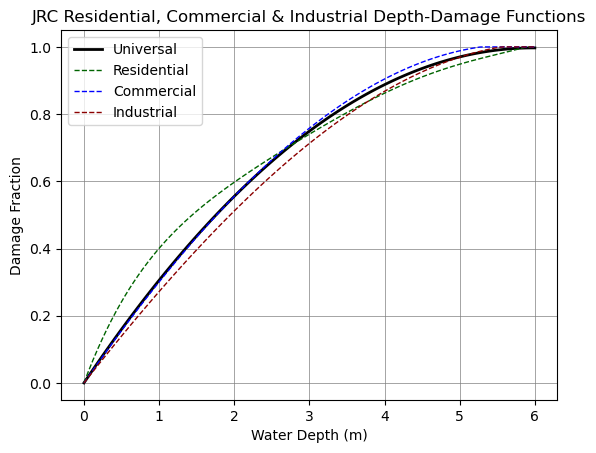

Done preparing detph-damage curves


In [4]:
# Define arrays for damage values based on 2010 estimates 
CPI2010 = 100                                  # 2010 EU Consumer Price Index Value
CPI2022 = 121.8                                # 2022 EU Consumer Price Index Value
CPI_Frac = CPI2022 / CPI2010
MaxDmgRES = np.array([480, 240]) * CPI_Frac    # EU Value, Residential
MaxDmgCOM = np.array([502, 502]) * CPI_Frac    # EU Value, Commercial
MaxDmgIND = np.array([328, 492]) * CPI_Frac    # EU Value, Industrial
MaxDmgAGR = np.array([0.23, 0.46]) * CPI_Frac  # Italy 2021 (AGR), Agricultural, currently not used
MaxDmgCUL = MaxDmgCOM                          # EU Value, Cultural, currently not used
MaxDmgTRS = MaxDmgIND                          # Italy 2021 (TRS), Transport, currently not used
MaxDmgUNI = (MaxDmgRES+MaxDmgCOM+MaxDmgIND)/3  # Universal class
# Combine damage arrays into a single array
MaxDmg = np.column_stack((MaxDmgRES, MaxDmgCOM, MaxDmgIND, MaxDmgUNI))

# Damage classes
DamageClasses = ['Residential', 'Commercial', 'Industrial','Universal']

def DamageFunction(wd1, coefs, wd_range=(0, 6)):
    wd = np.clip(wd1, *wd_range)
    y = coefs[0] * wd**5 + coefs[1] * wd**4 + coefs[2] * wd**3 \
        + coefs[3] * wd**2 + coefs[4] * wd + coefs[5]
    y = np.clip(y, 0, 1)
    return y

# Polynomial coefficients for each function
#   - Up to 5th order
#   - 1st value is highest order (5th) and last is intercept
coefs_UNI = [0.0,  0.0, 0.0, -0.02787, 0.3334, 0.0]
coefs_RES = [0.0005869, -0.01077, 0.07497, -0.2602, 0.5959, 0.0]
coefs_COM = [0.0, 0.0, -0.0009149, -0.02021, 0.3216, 0.0]
coefs_IND = [0.0, 0.0, -0.001202, -0.01225, 0.2852, 0.0]
coefs_TRS = [0.0, -0.00938, 0.07734, -0.2906, 0.7625, 0.0]
coefs_AGR = [0.0, -0.004601, 0.06114, -0.3061, 0.7773, 0.0]

# Plot Depth Damage Functions
# Water depth values from 0 to 6m
wd_values = np.linspace(0, 6, 100)
dmgRES = DamageFunction(wd_values, coefs_RES)
dmgCOM = DamageFunction(wd_values, coefs_COM)
dmgIND = DamageFunction(wd_values, coefs_IND)
dmgUNI = DamageFunction(wd_values, coefs_UNI)
if flagDamageCurve is True:
    plt.plot(wd_values, dmgUNI, color='black', linewidth=2, label='Universal')
    plt.plot(wd_values, dmgRES, color='darkgreen', linestyle='--', linewidth=1,
            label='Residential')
    plt.plot(wd_values, dmgCOM, color='blue', linestyle='--', linewidth=1,
            label='Commercial')
    plt.plot(wd_values, dmgIND, color='darkred', linestyle='--', linewidth=1,
            label='Industrial')
    plt.grid(color='grey', linestyle='-', linewidth=0.5)
    plt.xlabel('Water Depth (m)')
    plt.ylabel('Damage Fraction')
    plt.title('JRC Residential, Commercial & Industrial Depth-Damage Functions')
    plt.legend()
    plt.show()

print('Done preparing detph-damage curves')

## Retrieving data for the area of interest
In this section the bounding box is used to crop the data to the area of interest.
The code converts latitude and longitude values to the equivalent projection used by the flood map raster & writes bounding box to shapefile. We also define the bounding box for OpenStreetMap data.

If the region of interest is not as desired, the latitude and longitude values can be changed in the "Define inputs" section above.

Water Depth Raster Projection: EPSG:4326
Converted Coordinate Bounds with Buffer:
  Longitudes: 11.243140006053371E --> 11.243140006053371 meters & 11.285834098062859E --> 11.285834098062859 meters
  Latitudes: 43.75997739156569N --> 43.75997739156569 meters & 43.780954224448514N --> 43.780954224448514 meters
Bounding Box Shapefile written to: ./OSM/outline_florence.shp
./data/Europe_RP10_filled_depth.tif


/opt/tljh/user/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


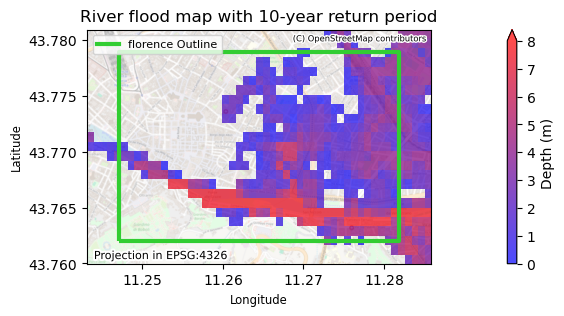

./data/Europe_RP500_filled_depth.tif


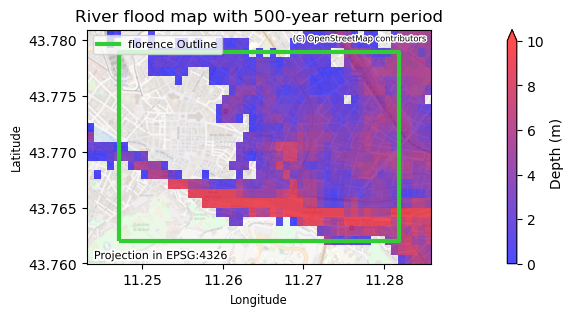

Population Raster Projection: EPSG:4326
Converted Coordinate Bounds with Buffer:
  Longitudes: 11.243140006053371E --> 11.243140006053371 meters & 11.285834098062859E --> 11.285834098062859 meters
  Latitudes: 43.75997739156569N --> 43.75997739156569 meters & 43.780954224448514N --> 43.780954224448514 meters


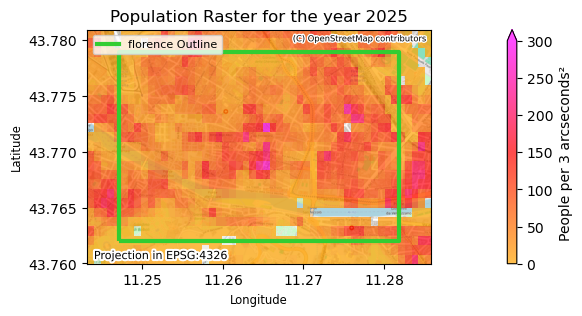

Done preparing data for AOI


In [5]:
#Set shape box location
shpBBox = os.path.join(dirOSM, f'outline_{saveName}.shp')

# Determine Raster EPSG Code (only works with osgeo)
ds = gdal.Open(depth_full_rasters[0])
srs = osr.SpatialReference()
srs.ImportFromWkt(ds.GetProjection())
epsgRast = f'EPSG:{srs.GetAuthorityCode(None)}'
ds = None

print(f'Water Depth Raster Projection: {epsgRast}')

# Create a transformer for coordinate conversion
transformer = Transformer.from_crs('EPSG:4326', epsgRast, always_xy=True)

# Convert bounding box coordinates to raster CRS
xMin, yMin = transformer.transform(Longitude1-xbuffer, Latitude1-ybuffer)
xMax, yMax = transformer.transform(Longitude2+xbuffer, Latitude2+ybuffer)

print('Converted Coordinate Bounds with Buffer:')
print(f'  Longitudes: {Longitude1-xbuffer}E --> {xMin} meters & {Longitude2+xbuffer}E --> {xMax} meters')
print(f'  Latitudes: {Latitude1-ybuffer}N --> {yMin} meters & {Latitude2+ybuffer}N --> {yMax} meters')

# Define the bounding box coordinates based on the zoomed region
bounding_box = gpd.GeoDataFrame(geometry=outlineGeometry)
# Write the GeoDataFrame to a shapefile
bounding_box.to_file(shpBBox)
print('Bounding Box Shapefile written to: '+shpBBox)

# Read GeoDataFrame from the bounding box shapefile
gdfBBox = gpd.read_file(shpBBox)
crsRast = gdfBBox.crs

for RP in ImageReturnPeriod:
    depth_full_raster = next((s for s in depth_full_rasters if f'RP{RP}_' in s), None)
    print(depth_full_raster)
    # Read the raster using rasterio
    with rasterio.open(depth_full_raster) as src:
        window = from_bounds(xMin, yMin, xMax, yMax, src.transform)
        rDepths = src.read(1, window=window)
        rDepths = np.ma.masked_where((rDepths <= 0) | (rDepths > 1000), rDepths)
        max_depth  = rDepths.max()
        if customMaxDepthLegend == -1:
            maxDepthLegend = ((max_depth // 1) + 1)
        else:
            maxDepthLegend=customMaxDepthLegend
        missing_data_value = src.nodata
    fig, ax = plt.subplots()
    im = ax.imshow(rDepths, vmin=0, vmax=maxDepthLegend, cmap=cmap_h2o, extent=(xMin, xMax, yMin, yMax),
                zorder=2, alpha=0.7)
    plt.title(f'River flood map with {RP}-year return period')
    plt.xlabel('Longitude', fontsize='small')
    plt.ylabel('Latitude', fontsize='small')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    plt.colorbar(im, cax=cax,label='Depth (m)',extend='max')
    plt.text(.02,.02,f'Projection in {epsgRast}', fontsize=8,
             path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
    ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
    ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
    ctx.add_basemap(ax=ax, crs=epsgRast, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.5)
    txt = ax.texts[-1]
    txt.set_position([0.99,0.98])
    txt.set_ha('right')
    txt.set_va('top')
    if showOutlineFlag is True:
        outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
    if outlineLabelFlag is True:
        outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
        legend_outline=ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
    if imageSaveFlag is True:
        plt.savefig(os.path.join(dirImages, f'{saveName}_floodmap_{RP}RP.png'), bbox_inches='tight')
    plt.show()

##--------------------------------------------------------
## Population map
# Open the raster file
ds = gdal.Open(pop_full_raster)
if ds is None:
    raise RuntimeError(f"Failed to open the raster file: {pop_full_raster}")

# Get the projection from the raster file
proj_wkt = ds.GetProjection()
srs = osr.SpatialReference()
srs.ImportFromWkt(proj_wkt)

# Try to get the EPSG code
epsg_code = srs.GetAuthorityCode(None)

# Check if the EPSG code was successfully retrieved
if epsg_code is None:
    # If not, you might need to handle specific cases manually
    # Check if the projection matches known projections
    proj4_str = srs.ExportToProj4()
    if '+proj=moll' in proj4_str and '+datum=WGS84' in proj4_str:
        epsg_code = 'EPSG:54009'  # ESRI:54009 World Mollweide projection
    else:
        raise RuntimeError("Unable to determine EPSG code for the given projection.")
else:
    epsg_code = f"EPSG:{epsg_code}"

epsgRastPop = epsg_code
# Close the dataset
ds = None
print(f'Population Raster Projection: {epsgRastPop}')

# Create a transformer for coordinate conversion
if epsg_code == 'EPSG:54009':
    PopProj = '+proj=moll +datum=WGS84 +units=m' #MOLLWEIDE HAS TO BE MANUALLY INSERTED
else:
    PopProj = epsg_code

transformer = Transformer.from_crs('EPSG:4326', PopProj, always_xy=True)

# Convert bounding box coordinates to raster CRS
xMinPop, yMinPop = transformer.transform(Longitude1-xbuffer, Latitude1-ybuffer)
xMaxPop, yMaxPop = transformer.transform(Longitude2+xbuffer, Latitude2+ybuffer)

# Ensure xMin < xMax and yMin < yMax
xMinPop, xMaxPop = min(xMinPop, xMaxPop), max(xMinPop, xMaxPop)
yMinPop, yMaxPop = min(yMinPop, yMaxPop), max(yMinPop, yMaxPop)

print('Converted Coordinate Bounds with Buffer:')
print(f'  Longitudes: {Longitude1-xbuffer}E --> {xMinPop} meters & {Longitude2+xbuffer}E --> {xMaxPop} meters')
print(f'  Latitudes: {Latitude1-ybuffer}N --> {yMinPop} meters & {Latitude2+ybuffer}N --> {yMaxPop} meters')

# Read the raster using rasterio
with rasterio.open(pop_full_raster) as src:
    window = from_bounds(xMinPop, yMinPop, xMaxPop, yMaxPop, src.transform)
    rPopulation = src.read(1, window=window)
    rPopulation = np.ma.masked_where((rPopulation < 0.1), rPopulation)
    max_population = rPopulation.max()
    maxPopLegend = ((max_population // 100) + 1) * 100
    missing_data_value = src.nodata


fig, ax = plt.subplots()
im = ax.imshow(rPopulation, vmin=0, vmax=maxPopLegend, cmap=cmap_pop, extent=(xMinPop, xMaxPop, yMinPop, yMaxPop),
               zorder=2, alpha=0.7)
plt.title(f'Population Raster for the year {PopYear}')
plt.xlabel('Longitude', fontsize='small')
plt.ylabel('Latitude', fontsize='small')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
plt.colorbar(im, cax=cax, label='People per 3 arcseconds\u00B2', extend='max')
plt.text(.02,.02,f'Projection in {epsgRastPop}', fontsize=8,
             path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
ctx.add_basemap(ax=ax, crs=epsgRastPop, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=1)
txt = ax.texts[-1]
txt.set_position([0.99,0.98])
txt.set_ha('right')
txt.set_va('top')
if showOutlineFlag is True:
    outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
if outlineLabelFlag is True:
    outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
    legend_outline=ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
if imageSaveFlag is True:
    plt.savefig(os.path.join(dirImages, f'{saveName}_populationmap_{PopYear}.png'), bbox_inches='tight')
plt.show()

print('Done preparing data for AOI')

### OpenStreetMap buildings data
In this section the OSM data are loaded based on the bounding box defined above. The extracted data represents the building use (unclassified) and is written to a shapefile.

/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'brand:wikidata' to 'brand_wiki'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'brand:wikipedia' to 'brand_wi_1'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'fuel:diesel' to 'fuel_diese'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'fuel:octane_95' to 'fuel_octan'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'ref:mise' to 'ref_mise'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'addr:housenumber' to 'addr_house'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/ra

OSM data read in and saved to shapefile
  ./OSM/florence_OSM_Building_Unclassified.shp


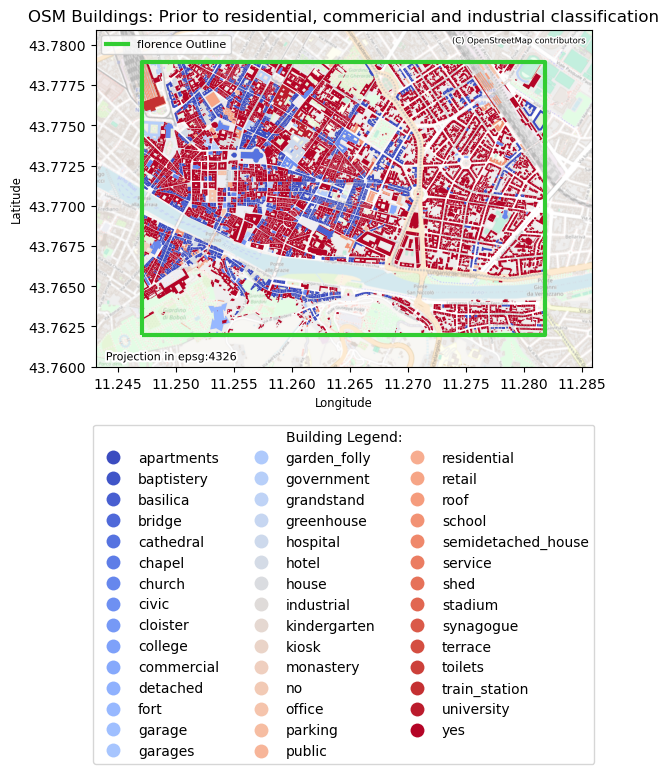

Done downloading OSM data for AOI


In [6]:
# Output shapefile for unclassified buildings
shpOSM = os.path.join(dirOSM, f'{saveName}_OSM_Building_Unclassified.shp')

# Define tags for OSM data
tags = {'building': True,'amenity': True}
# Retrieve OSM geometries within the bounding box
gdfOSM = ox.features_from_polygon(outlineGeometry.iloc[0], tags)
# Filter out non-Polygon geometries
gdfOSM = gdfOSM[gdfOSM.geom_type == 'Polygon']
# Confirm that all of the GDF elements are compatible with shp format
gdfOSM = gdfOSM.map(lambda x: str(x) if isinstance(x, list) else x)
# Clip the OSM data to the bounding box
gdfOSM = gpd.clip(gdfOSM, outlineGeometry)
# Save the polygon-only gdp to shapefile
warnings.simplefilter("ignore",category=UserWarning) #Removing UserWarning regarding truncated columns when saving to ESRI Shapefile
gdfOSM.to_file(shpOSM, driver='ESRI Shapefile', encoding='utf-8')
warnings.resetwarnings()
print('OSM data read in and saved to shapefile')
print('  '+shpOSM)

if flagBuilding is True:
    # Plot data
    fig, ax = plt.subplots()  # Adjust figsize as needed
    plt.title('OSM Buildings: Prior to residential, commericial and industrial classification')
    plt.xlabel('Longitude', fontsize='small')
    plt.ylabel('Latitude', fontsize='small')
    plt.text(.02,.02,f'Projection in {gdfOSM.crs}', fontsize=8,
              path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
    if showOutlineFlag is True:
        outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
    if outlineLabelFlag is True:
        outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
        legend_outline=ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
    gdfOSM.plot(column='building',ax=ax, legend=True, cmap='coolwarm',
                      legend_kwds={'ncol': 3, 'bbox_to_anchor': (.5, -0.15), 'loc': 'upper center', 'title': 'Building Legend:'})
    ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
    ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
    ctx.add_basemap(ax=ax, crs=gdfOSM.crs, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.5)
    txt = ax.texts[-1]
    txt.set_position([0.99,0.98])
    txt.set_ha('right')
    txt.set_va('top')
    if outlineLabelFlag is True:
        ax.add_artist(legend_outline)
    if imageSaveFlag is True:
        plt.savefig(os.path.join(dirImages, f'{saveName}_OSMbuilding_preclassification.png'), bbox_inches='tight')
    plt.show()

print('Done downloading OSM data for AOI')

### Reproject OSM data to raster projection
In this section, in order to perform the damage analysis, the OSM and raster data need to be on the same Coordinate Reference System (CRS). The OSM are on an EPSG:4326 CRS and the raster data could be another.  In the cell, the OSM data are converted to match the raster CRS.

In [7]:
# Determine CRSs from shapefile and Raster
crsOSM = gdfOSM.crs

if crsOSM not in (epsgRast, epsgRast.lower()):
    print(f'Reprojecting from OSM {crsOSM} to raster EPSG:{epsgRast}')
    # Read the GeoDataFrame if reprojection is needed
    gdfOSM = gpd.read_file(shpOSM)
    # Reproject the GeoDataFrame to match the raster CRS
    gdfOSM = gdfOSM.to_crs(epsg=epsgRast)
    # Save the reprojected data back to the shapefile
    gdfOSM.to_file(shpOSM)
    print('  Overwriting reprojected data:', shpOSM)

else:
    print('No reprojection performed. Both projections are the same:', crsOSM)

print('Done')

No reprojection performed. Both projections are the same: epsg:4326
Done


### Building classifications
In this section, the building types are classified to Residential, Commercial, Industrial, etc.
- This procedure needs to be performed manually by looking at the list of building types.
- If None is listed for a building class (bldgClass column), the building type (building column) should be assigned to one of the lists (e.g., classResidential, classCommercial, classIndustrial).
- Buildings with type "yes" will be classified as Universal by default in a later step.

As calculated in an earlier section, the Universal class has a damage curve equal to the average of the Residential, Commercial, and Industrial ones.

Below we have added a classification of OSM building types already.

In [8]:
# CSV file with classifications (classResidential, classCommercial, etc)
csvOSMclasses = os.path.join(dirOSM, f'{saveName}_OSM_Building_Reclassified.csv')
csvOSMamenity = os.path.join(dirOSM, f'{saveName}_OSM_Amenity_Classified.csv')
 # Keep only the building and geometry columns
gdfBuildings = gdfOSM[['building','amenity','geometry']].copy()

# Building classifications
#   - Change and add as needed 
classResidential = ['hut', 'apartments', 'detached', 'residential', 'house', 'barn', 'garage',
                    'carport', 'semidetached_house', 'shed', 'bungalow', 'roof', 'terrace',
                    'allotment_house']
classCommercial = ['commercial', 'office', 'retail', 'kiosk', 'supermarket', 'warehouse',
                   'garages', 'hotel', 'stadium', 'grandstand', 'sports_centre',  'pavilion',
                   'government', 'school', 'kindergarten', 'university', 'dormitory', 'public',
                   'service', 'hospital', 'civic', 'terminal', 'fire_station',
                   'train_station', 'boathouse', 'toilets', 'tech_cab', 'tower', 'portal',
                   'columbarium', 'greenhouse', 'guardhouse', 'construction',
                   'funeral_hall']
classIndustrial = ['industrial', 'manufacture']
classCultural = ['church', 'cathedral', 'baptistery', 'obelisk', 'basilica', 'monastery', 'ruins',
                 'column', 'chapel', 'synagogue', 'shrine', 'religious', 'convent', 'fort']
classAgricultural = ['farm_auxiliary']
classTransportation = ['bridge', 'parking']
classUniversal = ['universal']

# Critical infrastructure, add infrastructure of interest ------- 
#   - Change and add as needed, NB: Can classify critical infrastructure both through it's building or amenity tag.
#   - It is suggested to run this cell once, read the output below, and add the building or amenities required in the critical infrastructure list
criticalInfrastructureList = ['hospital','fuel','bank','clinic','pharmacy', 
                             'police','prison','refugee_site', 
                             'train_station',
                             'fire_station','transformer_tower','water_tower','bridge',
                             'transportation']
# This affects the look of the maps in the 'Critical Infrastructure' section
critMarkersColours = {
    'hospital': {'marker': 'P', 'color': 'red'}, 
    'police': {'marker': 's', 'color': 'blue'}, 
    'train_station': {'marker': 'o', 'color': 'green'}, 
    'transformer_tower': {'marker': '*', 'color': 'purple'}, 
    'water_tower': {'marker': 'v', 'color': 'orange'}, 
    'bridge': {'marker': 'd', 'color': 'brown'}, 
    'fire_station': {'marker': 'X', 'color': 'pink'}, 
    'transportation': {'marker': '>', 'color': 'cyan'}, 
    'refugee_site': {'marker': 'o', 'color': 'lime'},
    'fuel': {'marker': '2', 'color': 'yellow'},
}  
    #Here are some more example of marker and colours in case they are needed. Feel free to experiment:
    #OtherMarkerList=['^','p','D','H','X','h']; OtherColourList=['lime','darkgreen','navy','slategray','pink','magenta']

# For now, set transportation and cultural to universal (can add/change if desired)
classUniversal = classUniversal + classCultural + classAgricultural + classTransportation
classCultural = []
classAgricultural = []
classTransportation = []

# Convert building classes to dataframe
bldgClasses = pd.DataFrame({'building': gdfBuildings['building'].unique()})

# Classify each structure to Residential, Commercial, Industrial, etc.
#   - Structures not listed in above class lists are classified as none
bldgClasses['bldgClass'] = None
bldgClasses.loc[bldgClasses['building'].isin(classResidential), 'bldgClass'] = 'Residential'
bldgClasses.loc[bldgClasses['building'].isin(classCommercial), 'bldgClass'] = 'Commercial'
bldgClasses.loc[bldgClasses['building'].isin(classIndustrial), 'bldgClass'] = 'Industrial'
bldgClasses.loc[bldgClasses['building'].isin(classCultural), 'bldgClass'] = 'Cultural'
bldgClasses.loc[bldgClasses['building'].isin(classAgricultural), 'bldgClass'] = 'Agricultural'
bldgClasses.loc[bldgClasses['building'].isin(classTransportation), 'bldgClass'] = 'Transportation'
bldgClasses.loc[bldgClasses['building'].isin(classUniversal), 'bldgClass'] = 'Universal'

#   - Adding critical infrastructure
bldgClasses['critInfrastructure'] = None
bldgClasses.loc[bldgClasses['building'].isin(criticalInfrastructureList), 'critInfrastructure'] = True

amenityClasses = pd.DataFrame({'amenity': gdfBuildings['amenity'].unique()})
amenityClasses['critInfrastructure'] = None
amenityClasses.loc[amenityClasses['amenity'].isin(criticalInfrastructureList), 'critInfrastructure'] = True


# Write structure and classification to CSV
bldgClasses.to_csv(csvOSMclasses, index=False)
amenityClasses.to_csv(csvOSMamenity, index=False)

print('Building Classifications')
print('  - If None is listed for a building class, add the building one of the above lists.')
print("  - Building 'yes' will be classified as Universal in a later step.")
print(bldgClasses)
print(amenityClasses)

print('Done with reclassification definitions')

Building Classifications
  - If None is listed for a building class, add the building one of the above lists.
  - Building 'yes' will be classified as Universal in a later step.
              building    bldgClass critInfrastructure
0                  yes         None               None
1           apartments  Residential               None
2               garage  Residential               None
3   semidetached_house  Residential               None
4               retail   Commercial               None
5              garages   Commercial               None
6                  NaN         None               None
7               office   Commercial               None
8                 shed  Residential               None
9               church    Universal               None
10             toilets   Commercial               None
11          greenhouse   Commercial               None
12               house  Residential               None
13          government   Commercial               No

In the code below, the building types are classified and written to a ShapeFile with a column.
- The first map shows the buildings that have been classified based on the above assignments.
- The second map shows the same, but the with building type "yes" classified as Universal. The difference between the maps provides an idea of the how many building have a type assigned to them.

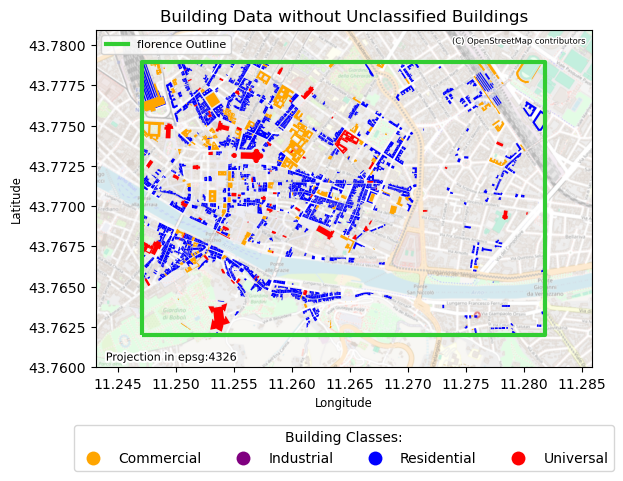

/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'brand:wikidata' to 'brand_wiki'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'brand:wikipedia' to 'brand_wi_1'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'fuel:diesel' to 'fuel_diese'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'fuel:octane_95' to 'fuel_octan'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'ref:mise' to 'ref_mise'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'addr:housenumber' to 'addr_house'
  ogr_write(
/opt/tljh/user/lib/python3.12/site-packages/pyogrio/ra

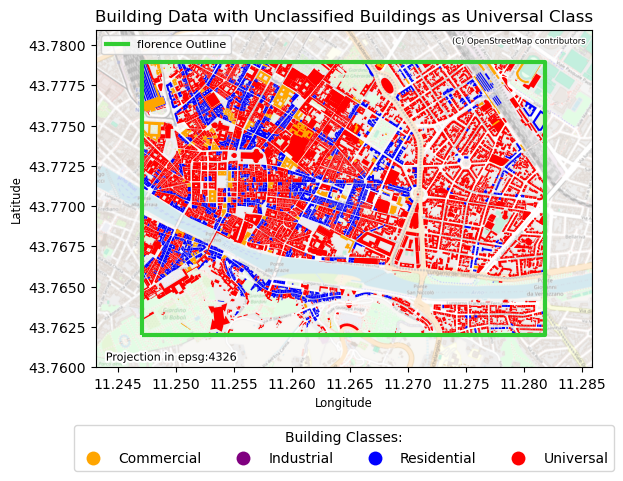

Done assigning classifications to buildings


In [9]:
# Shapefile name with reclassied buildings (output)
shpOSMreclass = os.path.join(dirOSM,f'{saveName}_OSM_Building_Reclassified.shp')

# Building classification created earlier
bldgClasses = pd.read_csv(csvOSMclasses)

# Merge the spatial data with the new information
gdfOSMreclass = pd.merge(gdfOSM, bldgClasses, on='building', how='left')

if flagBuilding is True:
    # Plot without unclassified buildings
    fig, ax = plt.subplots()  # Adjust figsize as needed
    plt.title('Building Data without Unclassified Buildings')
    plt.xlabel('Longitude', fontsize='small')
    plt.ylabel('Latitude', fontsize='small')
    plt.text(.02,.02,f'Projection in {gdfOSM.crs}', fontsize=8,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
    if showOutlineFlag is True:
        outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
    if outlineLabelFlag is True:
        outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
        legend_outline=ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
    gdfOSMreclass.plot(column='bldgClass', ax=ax, legend=True, cmap=cmap_cls,
                       legend_kwds={'ncol': 4, 'bbox_to_anchor': (.5, -0.15), 'loc': 'upper center', 'title': 'Building Classes:'})
    ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
    ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
    ctx.add_basemap(ax=ax, crs=gdfOSM.crs, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.5)
    txt = ax.texts[-1]
    txt.set_position([0.99,0.98])
    txt.set_ha('right')
    txt.set_va('top')
    if outlineLabelFlag is True:
        ax.add_artist(legend_outline)
    if imageSaveFlag is True:
        plt.savefig(os.path.join(dirImages, f'{saveName}_OSMbuilding_unclassified_simple.png'), bbox_inches='tight')
    plt.show()

# Substitute undefined (null) building classes
gdfOSMreclass['bldgClass'] = gdfOSMreclass['bldgClass'].fillna('Universal')

# Write classified structures to file
warnings.simplefilter("ignore",category=UserWarning) #Removing UserWarning regarding truncated columns when saving to ESRI Shapefile
gdfOSMreclass.to_file(shpOSMreclass, encoding='utf-8')
warnings.resetwarnings()

if flagBuilding is True:
    # Plot with unclassified buildings as classified
    fig, ax = plt.subplots()  # Adjust figsize as needed
    plt.title('Building Data with Unclassified Buildings as Universal Class')
    plt.xlabel('Longitude', fontsize='small')
    plt.ylabel('Latitude', fontsize='small')
    plt.text(.02,.02,f'Projection in {gdfOSM.crs}', fontsize=8,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
    if showOutlineFlag is True:
        outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
    if outlineLabelFlag is True:
        outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
        legend_outline=ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
    gdfOSMreclass.plot(column='bldgClass', ax=ax, legend=True, cmap=cmap_cls,
                       legend_kwds={'ncol': 4, 'bbox_to_anchor': (.5, -0.15), 'loc': 'upper center', 'title': 'Building Classes:'})
    ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
    ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
    ctx.add_basemap(ax=ax, crs=gdfOSM.crs, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.5)
    txt = ax.texts[-1]
    txt.set_position([0.99,0.98])
    txt.set_ha('right')
    txt.set_va('top')
    if outlineLabelFlag is True:
        ax.add_artist(legend_outline)
    if imageSaveFlag is True:
        plt.savefig(os.path.join(dirImages, f'{saveName}_OSMbuilding_classified_simple.png'), bbox_inches='tight')
    plt.show()

print('Done assigning classifications to buildings')

## Flood depths at building locations
In this section, the flood map rasters for each return period (extreme event) are loaded.
- The rasters are then translated to flood depths for each building based on the desired statistic (mean, maximum or minimum depth or all three).
- For each return period a plot of a flood map can be generated as well as a plot with the flood depths corresponding to each building.

Computing Building Water Depths:  RP= 10
  Loading water depth for selected bounds:  RP= 10
  ./data/Europe_RP10_filled_depth.tif


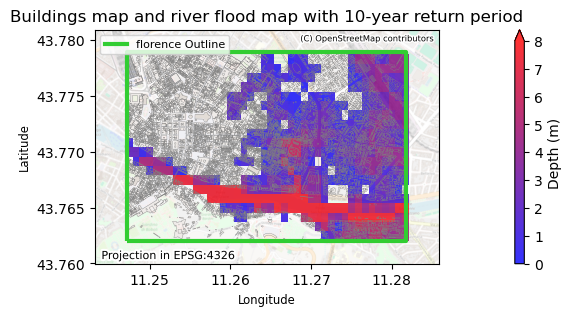

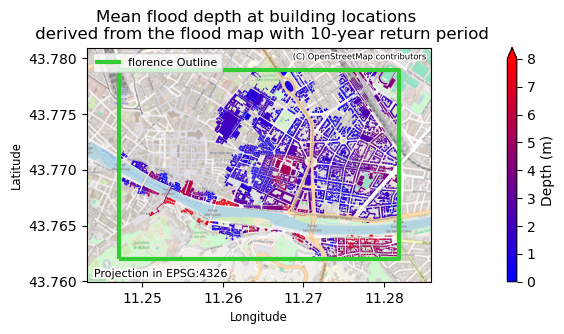

Computing Building Water Depths:  RP= 20
  Loading water depth for selected bounds:  RP= 20
  ./data/Europe_RP20_filled_depth.tif
Computing Building Water Depths:  RP= 30
  Loading water depth for selected bounds:  RP= 30
  ./data/Europe_RP30_filled_depth.tif


In [ ]:
depth_rasters = [file.replace('.tif', f'_{saveName}.tif') for file in depth_full_rasters]
depth_shapefiles = [file.replace('.tif', '.shp') for file in depth_rasters]
depth_shapefiles = [file.replace('/ID', f'/{saveName}_ID') for file in depth_shapefiles]
depth_shapefiles = [file.replace(dirDepths, dirResults) for file in depth_shapefiles]

for RP in return_periods:

    depth_full_raster = next((s for s in depth_full_rasters if f'RP{RP}_' in s), None)
    depth_raster = next((s for s in depth_rasters if f'RP{RP}_' in s), None)
    depth_shapefile = next((s for s in depth_shapefiles if f'RP{RP}_' in s), None)

    print("Computing Building Water Depths:  RP=", str(RP))
    print('  Loading water depth for selected bounds:  RP=', str(RP))
    print(f'  {depth_full_raster}')

    # Keep only the building, bldgClass and geometry columns

    gdfDamage = gdfOSMreclass[['building', 'bldgClass', 'geometry']].copy()

    # Compute building areas in m2
    gdfDamage_ESPG3035=gdfDamage.to_crs(3035)
    gdfDamage['Area_m2'] = gdfDamage_ESPG3035.geometry.area

    # Read the raster using rasterio
    with rasterio.open(depth_full_raster) as src:
        rDepths, out_transform = mask(src, outlineGeometry, crop=True)
        rDepths = rDepths[0]
        rDepths = np.ma.masked_where((rDepths <= 0) | (rDepths > 1000), rDepths)
        missing_data_value = src.nodata
        if missing_data_value is None:
            missing_data_value = -9999
        max_depth  = rDepths.max()
        with rasterio.open(
            depth_raster,
            'w',
            driver='GTiff',
            height=rDepths.shape[0],
            width=rDepths.shape[1],
            count=1,
            dtype=rDepths.dtype,
            crs=src.crs,
            transform=out_transform,
            nodata=missing_data_value
        ) as dst:
            dst.write(rDepths, 1)
    height, width = rDepths.shape
    xMinDepth, yMinDepth, xMaxDepth, yMaxDepth = array_bounds(height, width, out_transform)    
    # Perform zonal statistics directly on the raster array        
    result = rasterstats.zonal_stats(
        gdfDamage,
        rDepths,
        nodata=src.nodata,
        affine=out_transform,
        stats=['mean', 'min', 'max'],
        all_touched=True
    )

    # Update geodataframe with zonal statistics
    gdfDamage["MeanDepth"] = [entry["mean"] for entry in result]
    gdfDamage["MinDepth"] = [entry["min"] for entry in result]
    gdfDamage["MaxDepth"] = [entry["max"] for entry in result]

    if customMaxDepthLegend == -1:
        maxDepthLegend = ((max_depth // 1) + 1)
    else:
        maxDepthLegend=customMaxDepthLegend

    if RP in ImageReturnPeriod and flagBuildingH2o is True:
        fig, ax = plt.subplots()
        plt.title(f'Buildings map and river flood map with {RP}-year return period')
        plt.xlabel('Longitude', fontsize='small')
        plt.ylabel('Latitude', fontsize='small')
        im = ax.imshow(rDepths, vmin=0, vmax=maxDepthLegend, cmap=cmap_h2o, extent=(xMinDepth, xMaxDepth, yMinDepth, yMaxDepth), zorder=1, alpha=0.8)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        plt.colorbar(im, cax=cax,label='Depth (m)',extend='max')
        plt.text(.02,.02,f'Projection in {epsgRast}', fontsize=8,
             path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
        gdfDamage.plot(ax=ax, edgecolor='grey', linewidth=0.25, facecolor='none')
        ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
        ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
        ctx.add_basemap(ax=ax, crs=epsgRast, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.4)
        txt = ax.texts[-1]
        txt.set_position([0.99,0.98])
        txt.set_ha('right')
        txt.set_va('top')
        if showOutlineFlag is True:
            outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
            if outlineLabelFlag is True:
                outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
                ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
        if imageSaveFlag is True:
            plt.savefig(os.path.join(dirImages, f'{saveName}_buildingoutline_floodmap_{RP}RP.png'), bbox_inches='tight')
        plt.show()
        
        # Map depths > 0 at building level
        gdf_filtered = gdfDamage[(gdfDamage['MeanDepth'] > 0) | (gdfDamage['MinDepth'] > 0) | (gdfDamage['MaxDepth'] > 0)]
        
        fig, ax = plt.subplots()
        plt.title(f'Mean flood depth at building locations \n derived from the flood map with {RP}-year return period')
        plt.xlabel('Longitude', fontsize='small')
        plt.ylabel('Latitude', fontsize='small')
        plot = gdf_filtered.plot(column='MeanDepth', vmin=0, vmax=maxDepthLegend, cmap=cmap_h2o, ax=ax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        plt.colorbar(plot.collections[0], cax=cax,label='Depth (m)',extend='max')
        plt.text(.02,.02,f'Projection in {epsgRast}', fontsize=8,
             path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
        ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
        ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
        ctx.add_basemap(ax=ax, crs=gdf_filtered.crs, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.9)
        txt = ax.texts[-1]
        txt.set_position([0.99,0.98])
        txt.set_ha('right')
        txt.set_va('top')  
        if showOutlineFlag is True:
            outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
            if outlineLabelFlag is True:
                outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
                ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
        if imageSaveFlag is True:
            plt.savefig(os.path.join(dirImages, f'{saveName}_building_flooddepth_{RP}RP.png'), bbox_inches='tight')
        plt.show()

    # Save the updated geodataframe to a shapefile
    gdfDamage.to_file(depth_shapefile, driver='ESRI Shapefile')

print('Done computing flood depths at each building')

### Calculating economic damage to buildings
Based on the flood water depths, the damage to the buildings (reconstruction costs) and for its contents are determined.
- First the fractional building damage is calculated applying the JRC damage functions for each classifiction (residential, commerical, etc).
- Then the fractional damage is multiplied with the maximum damage value per square meter and the building footprint area in meters and written to a shapefile.
- The damages in millions of Euros summed over all of the classes and plotted for each return period level.

In [ ]:
for RP in return_periods:
    depth_shapefile = next((s for s in depth_shapefiles if f'RP{RP}_' in s), None)

    # Read Building Water Depth Shapefile
    gdfDamage = gpd.read_file(depth_shapefile)

    for Depth in Depths:

        if Depth == 'Mean':
            depthStat = 'mean'
        elif Depth == 'Max':
            depthStat = 'max'
        elif Depth == 'Min':
            depthStat = 'min'
        else:
            print('Depth statistic does not exist.')
            print('  Current options are Mean, Max, and Min')
            sys.exit()

        print(f'Computing damage for {Depth.lower()} building depth. RP={str(RP)}.')
        
        statName = depthStat.title() + 'Depth'

        # Compute the damage factor for each building class

        gdfDamage['TotDamage'] = 0  # Initialize TotalDamage column

        for dmgClass in DamageClasses:

            bldgDamage='f'+dmgClass[:3].upper()+depthStat
            dmgName = 'Dmg'+bldgDamage[1:]
            # Damage factors and maximum damage value including contents
            if dmgClass == 'Residential':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_RES)
                MaxDmg = MaxDmgRES.sum()
            elif dmgClass == 'Commercial':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_COM)
                MaxDmg = MaxDmgCOM.sum()
            elif dmgClass == 'Industrial':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_IND)
                MaxDmg = MaxDmgIND.sum()
            elif dmgClass == 'Transportation':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_TRS)
                MaxDmg = MaxDmgTRS.sum()
            elif dmgClass == 'Agriculture':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_AGR)
                MaxDmg = MaxDmgAGR.sum()
            elif dmgClass == 'Universal':
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_UNI)
                MaxDmg = MaxDmgUNI.sum()
            else:
                gdfDamage[bldgDamage] = DamageFunction(gdfDamage[statName], coefs_UNI)
                MaxDmg = MaxDmgUNI.sum()

            # Damage computation
            gdfDamage.loc[gdfDamage['bldgClass'] != dmgClass, bldgDamage] = 0
            gdfDamage[dmgName] = gdfDamage[bldgDamage] * gdfDamage['Area_m2'] * MaxDmg

            # Add TotalDamage in millions of €
            gdfDamage['TotDamage'] += gdfDamage[dmgName] / 10**6

        gdfDamage.to_file(depth_shapefile, driver='ESRI Shapefile')

        # Plotting the GeoDataFrame with filtered values
        if RP in ImageReturnPeriod and flagBuildingDmg is True:
            fig, ax = plt.subplots()
            plt.title(f'Damage to buildings by {Depth.lower()} flood depth\nbased on the flood map with {str(RP)}-year return period')
            plt.xlabel('Longitude', fontsize='small')
            plt.ylabel('Latitude', fontsize='small')
            gdf_filtered = gdfDamage[(gdfDamage['TotDamage'] > 0)]
            plot = gdf_filtered.plot(column='TotDamage', cmap=cmap_dmg, ax=ax,zorder=2)
            
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="2%", pad=0.1)
            plt.colorbar(plot.collections[0], cax=cax,label='Damage (Mil €)',extend='max')
            
            plt.text(.02,.02,f'Projection in {gdf_filtered.crs}', fontsize=8,path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
            ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
            ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
            ctx.add_basemap(ax=ax, crs=gdf_filtered.crs, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.9)
            txt = ax.texts[-1]
            txt.set_position([0.99,0.98])
            txt.set_ha('right')
            txt.set_va('top')
            if showOutlineFlag is True:
                outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
                if outlineLabelFlag is True:
                    outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
                    ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
            if imageSaveFlag is True:
                plt.savefig(os.path.join(dirImages, f'{saveName}_building_damage_{Depth.lower()}depth_{RP}RP.png'), bbox_inches='tight')
            plt.show()

print('Done computing damage for each building')

### Total damage to buildings
In this section the total damage for the region of interest is summed and written to a CSV file.

In [ ]:
nDmg = np.append(DamageClasses, 'Total')

dfDMGs = pd.DataFrame(columns=[])
dfDMGs.index = nDmg
dfDMGs.index.name = 'Building Class'

for Depth in Depths:

    if Depth not in ['Mean', 'Max', 'Min']:
        print('Depth statistic does not exist.')
        print('  Current options are Mean, Minimum, and Maximum')
        sys.exit()

    print(f'Damage for {Depth} depth')

    for RP in return_periods:

        depth_shapefile = next((s for s in depth_shapefiles if f'RP{RP}_' in s), None)
        gdfOSM = gpd.read_file(depth_shapefile)

        vDmg = pd.DataFrame(columns=[])
        for dmgClass in DamageClasses:
            dmgName = f'DmgTRS{Depth.lower()}' if dmgClass == 'Transportation' else \
            f'Dmg{dmgClass[:3].upper()}{Depth.lower()}'
            vDmg = np.append(vDmg, gdfOSM[dmgName].sum())

        totDmg = sum(vDmg)
        vDmg = np.append(vDmg, totDmg)
        totDmg_byclass = pd.DataFrame(vDmg)
        # Assign names to the dataframe headers
        totDmg_byclass.columns = [f'{RP}-yr']
        totDmg_byclass.index = [nDmg]

        # Compute the total damage across the entire area of interest
        print(f'  RP={RP}-yr: Total damage (€) = {round(totDmg, 3)}')

        dfDMGs[f'{RP}-yr'] = np.array(totDmg_byclass)

    damage_csv_filename = os.path.join(dirResults, f'{saveName}_DamageTotal_{Depth}.csv')
    dfDMGs.to_csv(damage_csv_filename)

print('Done')

### Expected annual damage
In this section the plot of building damages vs return periods of the flood maps is generated.
Moreover, by integrating the curve, an estimate of the expected annual damage (EAD) in millions of Euros is provided. EAD is the damage that the region would expect on average in any given year.

In [ ]:
max_yaxis=0
vert_spacer=0
for Depth in Depths:
    if Depth == 'Mean':
        depthStat = 'mean'
    elif Depth == 'Max':
        depthStat = 'max'
    elif Depth == 'Min':
        depthStat = 'min'
    else:
        print('Depth statistic does not exist.')
        print('  Current options are Mean, Minimum, and Maximum')
        sys.exit()

    # Load damage data for the current depth statistic
    damage_csv_filename = os.path.join(dirResults, f'{saveName}_DamageTotal_{Depth}.csv')
    dfDMGs = pd.read_csv(damage_csv_filename, index_col=0)

    # Compute the total Estimated Annual Damage (EAD) over all return periods
    probRPs = 1 / np.array(return_periods)
    iTot = dfDMGs.index.get_loc('Total')
    EAD = 0
    for iRP in range(len(return_periods)-1):
        diffRP = probRPs[iRP] - probRPs[iRP+1]
        avgDMG = (dfDMGs.iloc[iTot, iRP+1] + dfDMGs.iloc[iTot, iRP]) / 2
        EAD = EAD + avgDMG * diffRP
        graphText = f'{Depth} Expected Annual Damage: {round(EAD/10**6, 2)} Mil €'

    # Plot estimated direct damage vs exceedance probability
    if flagBuildingDmgGraph is True:
        totDmg = dfDMGs.loc['Total'] / 10**6
        max_yaxis_current=totDmg.max()
        max_yaxis=max(max_yaxis,max_yaxis_current)
        plt.plot(np.array(return_periods), totDmg, marker='o', linestyle='-')
        plt.ylim(0)
        plt.grid(which='both', linestyle=':', linewidth=0.5, color='gray',dashes=(1,5))
        plt.xlabel('Event return period (Years)')
        plt.ylabel('Estimated Direct Damage (Mil €)')
        plt.text(0.96, 0.05+vert_spacer, graphText, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    print(graphText)
    vert_spacer=vert_spacer+0.08
yaxis_buffer=50 #This sets the y axis max to be the smallest multiple larger than the max value (eg: if yaxis_buffer=100, and the max value is 280, the yaxis max will be 300)
plt.ylim(0, ((max_yaxis // yaxis_buffer) + 1) * yaxis_buffer)
if len(Depths) > 1:
    plt.legend(Depths,title="Flood depth used at\nbuilding location:",fontsize='small',title_fontsize='small',
           loc='upper left', bbox_to_anchor=(1, 1),
          fancybox=True)
    plt.title('Estimated damage to buildings based on\nflood depth at building locations')
else:
    plt.title(f'Estimated damage to buildings based on\n{Depth.lower()} flood depth at building locations')
if imageSaveFlag is True:
    plt.savefig(os.path.join(dirImages, f'{saveName}_damage_graph.png'), bbox_inches='tight')
plt.show()

print('Done computing expected annual damage')

### Critical Infrastructure
In order to visualise the exposure of critical infrastructure for the area of interest, the OSM dataset is used:
- Markers and colours are attributed for each type of critical infrastructure.
- Flood water depths are read.
- Critical infrastructure and floods are mapped together.

Note that preference will be given to amenity classes over building classes, to avoid duplicates. Therefore there might be cases where certain OSM entries will not show up in the map.

In [ ]:
# Ensure the critical column is boolean
gdfOSMreclass['critInfrastructure'] = gdfOSMreclass['critInfrastructure'].infer_objects(copy=False)

for RP in ImageReturnPeriod:
    depth_raster = next((s for s in depth_rasters if f'RP{RP}_' in s), None)

    # Read the TIFF image
    with rasterio.open(depth_raster) as src:
        rDepths = src.read(1)  # Reading the first band
        rDepths = np.ma.masked_where((rDepths < -999) | (rDepths > 1000), rDepths)
        # Compute the maximum value from the masked data
        max_depth  = rDepths.max()
        if customMaxDepthLegend == -1:
            maxDepthLegend = ((max_depth // 1) + 1)
        else:
            maxDepthLegend=customMaxDepthLegend
        missing_data_value = src.nodata

    fig=plt.figure()
    ax = plt.axes()
    im = ax.imshow(rDepths, vmin=0, vmax=maxDepthLegend, cmap=cmap_h2o, extent=(xMinDepth, xMaxDepth, yMinDepth, yMaxDepth),
                zorder=1, alpha=0.6)
    plt.title(f'Critical infrastructure exposure to river floods with {RP}-year return period')
    divider = make_axes_locatable(ax)
    plt.xlabel('Longitude', fontsize='small')
    plt.ylabel('Latitude', fontsize='small')
    cax = divider.append_axes("right", size="2%", pad=0.1)
    plt.colorbar(im, cax=cax,label='Depth (m)',extend='max')
    plt.text(.02,.02,f'Projection in {gdfDamage.crs}', fontsize=8,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)

    # Collect critical buildings for all building types
    for building_type, props in critMarkersColours.items():
        markerItem = props['marker']
        colourItem = props['color']
        # Check for building type in 'amenity' or 'building' columns
        if building_type in gdfOSMreclass['amenity'].unique():
            crit_buildings = gdfOSMreclass[gdfOSMreclass['amenity'] == building_type]
        elif building_type in gdfOSMreclass['building'].unique():
            crit_buildings = gdfOSMreclass[gdfOSMreclass['building'] == building_type]
        else:
            continue
        crit_buildings_geometry = crit_buildings.geometry
        crit_buildings_geometry = crit_buildings_geometry.to_crs('EPSG:3857')
        crit_buildings_centroids = crit_buildings_geometry.centroid
        transformer = Transformer.from_crs('EPSG:3857', gdfOSMreclass.crs, always_xy=True)
        reprojected_centroids = []
        for centroid in crit_buildings_centroids:
            x, y = transformer.transform(centroid.x, centroid.y)  # Reproject the coordinates
            reprojected_centroids.append(Point(x, y))
        crit_buildings_centroids_reprojected = gpd.GeoSeries(reprojected_centroids, crs=gdfOSMreclass.crs)
        ax.scatter(crit_buildings_centroids_reprojected.x, crit_buildings_centroids_reprojected.y, color=colourItem, marker=markerItem, s=100,
                linewidths=.8, edgecolors='k', label=f'{building_type.capitalize()}',zorder=6) #change s value for the size of markers
    # Optionally, add basemap if needed
    ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
    ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
    ctx.add_basemap(ax=ax, crs=gdfDamage.crs, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=0.5)
    txt = ax.texts[-1]
    txt.set_position([0.99,0.98])
    txt.set_ha('right')
    txt.set_va('top')
    #Legend
    if showOutlineFlag is True:
        outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
    if outlineLabelFlag is True:
        outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
        legend_outline=ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)

    legend = ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.11),
                        title='Critical infrastructure type:')
    ax.tick_params(direction='out', length=8, width=.8,
                    labelsize=7)
    
    if outlineLabelFlag is True:
        ax.add_artist(legend_outline)
        
    if imageSaveFlag is True:
        plt.savefig(os.path.join(dirImages, f'{saveName}_criticalinfrastructure_{RP}RP.png'), bbox_inches='tight')
    plt.show()

print('Done with critical infrastructure exposure')

### Exposed population
Based on the flood depth maps, the exposed population is determined.
- The population and flood rasters are compared.
- The exposed population is written to a CSV file.
- A map of the exposed popoulation is produced.
- The exposed population is plotted against the flood map return period.

Expected annual exposed population is also calculated, representing the expected number of people exposed on average in any given year.

Please note that due to the resolution of both the population and the flood maps, it might be that part of the population appears to be over a water body (eg: a river) and is counted towards the overall exposed statistics.

In [ ]:
print('  Loading population for selected bounds:')
pop_raster = pop_full_raster.replace('.tif', f'_{saveName}.tif')
pop_exposed_rasters = [file.replace(saveName, f'_pop_exposed_{saveName}') for file in depth_rasters]
print(f'  {pop_raster}')

# Load the population data within the specified bounds
with rasterio.open(pop_full_raster) as src:
    window = from_bounds(xMinPop, yMinPop, xMaxPop, yMaxPop, src.transform)
    rPopulation = src.read(1, window=window)
    rPopulation = np.ma.masked_where(rPopulation < 0.0, rPopulation)
    missing_data_value = src.nodata

    # Save the zoomed population raster
    with rasterio.open(
        pop_raster,
        'w',
        driver='GTiff',
        height=rPopulation.shape[0],
        width=rPopulation.shape[1],
        count=1,
        dtype=rPopulation.dtype,
        crs=src.crs,
        transform=src.window_transform(window),
        nodata=missing_data_value
    ) as dst:
        dst.write(rPopulation, 1)


#Initialise population exposed array
exposedPop = []

# Process each return period
for RP in return_periods:
    depth_raster = next((s for s in depth_rasters if f'RP{RP}_' in s), None)
    pop_exposed_raster = next((s for s in pop_exposed_rasters if f'RP{RP}_' in s), None)
    with rasterio.open(depth_raster) as flood_src:
        rastDepths_data = flood_src.read(1)

        # Reproject the population raster to match the projection of the depths raster
        with rasterio.open(pop_raster) as pop_src:
            pop_data = pop_src.read(1)
            pop_transform, pop_width, pop_height = calculate_default_transform(
                pop_src.crs, flood_src.crs, pop_src.width, pop_src.height, *pop_src.bounds
            )
            pop_profile = pop_src.profile.copy()
            pop_profile.update({
                'crs': flood_src.crs,
                'transform': pop_transform,
                'width': pop_width,
                'height': pop_height
            })

            # Create an empty array to store the reprojected population data
            reprojected_pop_data = np.zeros((flood_src.height, flood_src.width), dtype=pop_data.dtype)
            reproject(
                pop_data,
                reprojected_pop_data,
                src_transform=pop_src.transform,
                src_crs=pop_src.crs,
                dst_transform=pop_transform,
                dst_crs=flood_src.crs,
                resampling=Resampling.nearest
            )

            # Find the spatial intersection between the depths raster and the reprojected population raster
            exposed_population = np.where(rastDepths_data > minDepthExposed, 1, 0) * reprojected_pop_data

            # Sum the exposed population
            total_exposed = np.sum(exposed_population)
            exposedPop.append(total_exposed)

            with rasterio.open(
                pop_exposed_raster,
                'w',
                driver='GTiff',
                height=exposed_population.shape[0],
                width=exposed_population.shape[1],
                count=1,
                dtype=exposed_population.dtype,
                crs=flood_src.crs,
                transform=flood_src.transform,
            ) as dst:
                dst.write(exposed_population, 1)
    if len(exposed_population.shape) == 3:
        height, width = exposed_population.shape[1], exposed_population.shape[2]
    elif len(exposed_population.shape) == 2:
        height, width = exposed_population.shape
    xMinExpPop, yMinExpPop, xMaxExpPop, yMaxExpPop = array_bounds(height, width, out_transform)   

    if RP in ImageReturnPeriod and flagPopulationExp is True:
        # Plot rasters
        fig, ax = plt.subplots()
        plt.title(f'Exposed population for the river flood event with {RP}-year return period\n(Population statistics based on estimate for the year {PopYear})')
        im = ax.imshow(np.ma.masked_where((exposed_population <= 0), exposed_population), cmap=cmap_pop, extent=(xMinExpPop, xMaxExpPop, yMinExpPop, yMaxExpPop),
                       zorder=2,alpha=0.8)
        plt.xlabel('Longitude', fontsize='small')
        plt.ylabel('Latitude', fontsize='small')
       
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        plt.colorbar(im, cax=cax, label='People Exposed', extend='max')
        plt.text(0, -.27, f'Exposed if Water Depth >{minDepthExposed}m', transform=ax.transAxes, fontsize=8,
             verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
        plt.text(.02,.02,f'Projection in {epsgRastPop}', fontsize=8,path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
        ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
        ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
        ctx.add_basemap(ax=ax, crs=epsgRastPop, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=1)
        txt = ax.texts[-1]
        txt.set_position([0.99,0.98])
        txt.set_ha('right')
        txt.set_va('top')
        if showOutlineFlag is True:
            outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
        if outlineLabelFlag is True:
            outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
            legend_outline=ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
        if imageSaveFlag is True:
            plt.savefig(os.path.join(dirImages, f'{saveName}_popexposed_map_{RP}RP.png'), bbox_inches='tight')
        plt.show()              


# Compute the total Estimated Annual Exposed Population (EAEP) over all return periods
EAEP = 0
for iRP in range(len(return_periods)-1):
    diffRP = probRPs[iRP] - probRPs[iRP+1]
    avgPOP = (exposedPop[iRP+1] + exposedPop[iRP]) / 2
    EAEP = EAEP + avgPOP * diffRP

if flagPopulationExpGraph is True:
    plt.plot(np.array(return_periods), exposedPop, marker='o', linestyle='-')
    plt.ylim(0)
    plt.grid(which='both', linestyle=':', linewidth=0.5, color='gray',dashes=(1,5))
    plt.xlabel('Event Return Period (Years)')
    plt.ylabel('People')
    plt.title(f'Estimated exposed population per flood event return period\n(Population statistics based on estimate for the year {PopYear})')
    graphText = f'Expected annual population exposed: {round(EAEP)} people.'
    plt.text(0.96, 0.05, graphText, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    
    if imageSaveFlag is True:
        plt.savefig(os.path.join(dirImages, f'{saveName}_popexposed_graph.png'), bbox_inches='tight')
    plt.show()

print(graphText)

#CSV FILE
dfPOP = pd.DataFrame(columns=[])
dfPOP.index = return_periods
dfPOP.index.name = 'Flood event return period (years)'
dfPOP['People Exposed'] = exposedPop
population_csv_filename = os.path.join(dirResultsPop, f'{saveName}_ExposedPopulationTotal.csv')
dfPOP.to_csv(population_csv_filename)

print('Done computing exposed population')

### Displaced population
Based on the flood depth maps, the displaced population is a subset of the exposed population that experience flood depths above a given threshold. 
- The population and flood rasters are compared.
- The displaced population is written to a CSV file.
- A map of the displaced population is produced.
- The plot of displaced population vs flood map return period is produced.

Expected annual displaced population is also calculated, representing the expected number of people displaced on average per year.

Please note that due to the resolution of both the population and the flood maps, it might be that part of the population appears to be over a water body (eg: a river) and is counted towards the overall displaced statistics.

In [ ]:
pop_displaced_rasters = [file.replace('exposed', 'displaced') for file in pop_exposed_rasters]

# Initialise displaced population array
displacedPop = []
# Process each return period
for RP in return_periods:
    depth_raster = next((s for s in depth_rasters if f'RP{RP}_' in s), None)
    pop_displaced_raster = next((s for s in pop_displaced_rasters if f'RP{RP}_' in s), None)
    with rasterio.open(depth_raster) as flood_src:
        rastDepths_data = flood_src.read(1)

        # Reproject the population raster to match the projection of the depths raster
        with rasterio.open(pop_raster) as pop_src:
            pop_data = pop_src.read(1)
            pop_transform, pop_width, pop_height = calculate_default_transform(
                pop_src.crs, flood_src.crs, pop_src.width, pop_src.height, *pop_src.bounds
            )
            pop_profile = pop_src.profile.copy()
            pop_profile.update({
                'crs': flood_src.crs,
                'transform': pop_transform,
                'width': pop_width,
                'height': pop_height
            })

            # Create an empty array to store the reprojected population data
            reprojected_pop_data = np.zeros((flood_src.height, flood_src.width), dtype=pop_data.dtype)
            reproject(
                pop_data,
                reprojected_pop_data,
                src_transform=pop_src.transform,
                src_crs=pop_src.crs,
                dst_transform=pop_transform,
                dst_crs=flood_src.crs,
                resampling=Resampling.nearest
            )

            # Find the spatial intersection between the depths raster and the reprojected population raster
            displaced_population = np.where(rastDepths_data > minDepthDisplaced, 1, 0) * reprojected_pop_data

            # Sum the exposed population
            total_displaced = np.sum(displaced_population)
            displacedPop.append(total_displaced)

            # Save the result raster for the exposed population
            with rasterio.open(
                pop_displaced_raster,
                'w',
                driver='GTiff',
                height=displaced_population.shape[0],
                width=displaced_population.shape[1],
                count=1,
                dtype=displaced_population.dtype,
                crs=flood_src.crs,
                transform=flood_src.transform,
            ) as dst:
                dst.write(displaced_population, 1)
    if len(displaced_population.shape) == 3:
        height, width = displaced_population.shape[1], displaced_population.shape[2]
    elif len(displaced_population.shape) == 2:
        height, width = displaced_population.shape
    xMinDisPop, yMinDisPop, xMaxDisPop, yMaxDisPop = array_bounds(height, width, out_transform)  

    if RP in ImageReturnPeriod and flagPopulationDis is True:
    # Plot rasters
        fig, ax = plt.subplots()
        plt.title(f'Displaced population for the river flood event with {RP}-year return period\n(Population statistics based on estimate for the year {PopYear})')
        im = ax.imshow(np.ma.masked_where((displaced_population <= 0), displaced_population), cmap=cmap_pop, extent=(xMinDisPop, xMaxDisPop, yMinDisPop, yMaxDisPop),
                       zorder=2,alpha=0.8)
        plt.xlabel('Longitude', fontsize='small')
        plt.ylabel('Latitude', fontsize='small')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        plt.colorbar(im, cax=cax, label='People Displaced', extend='max')
        plt.text(0.00, -0.27, f'Displaced if flood depth >{minDepthDisplaced}m', transform=ax.transAxes, fontsize=8,
             verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
        plt.text(.02,.02,f'Projection in {epsgRastPop}', fontsize=8,path_effects=[pe.withStroke(linewidth=3, foreground="white")], transform=ax.transAxes,zorder=7)
        ax.set_xlim(Longitude1-xbuffer,Longitude2+xbuffer)
        ax.set_ylim(Latitude1-ybuffer,Latitude2+ybuffer)
        ctx.add_basemap(ax=ax, crs=epsgRastPop, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size='6', alpha=1)
        txt = ax.texts[-1]
        txt.set_position([0.99,0.98])
        txt.set_ha('right')
        txt.set_va('top')
        if showOutlineFlag is True:
            outlineGeometry.plot(ax=ax, edgecolor=outlineColour, linestyle=outlineStyle, linewidth=outlineThickness, facecolor=outlineFace, alpha=outlineAlpha, zorder=5)
        if outlineLabelFlag is True:
            outline_legend = mlines.Line2D([], [], color=outlineColour, linewidth=outlineThickness, label=outlineLabel)
            legend_outline=ax.legend(handles=[outline_legend], loc=outlineLabelPosition, fontsize=outlineLabelSize, frameon=True)
        if imageSaveFlag is True:
            plt.savefig(os.path.join(dirImages, f'{saveName}_popdisplaced_map_{RP}RP.png'), bbox_inches='tight')
        plt.show()              

# Compute the total Estimated Annual Displaced Population (EADP) over all return periods
EADP = 0
for iRP in range(len(return_periods)-1):
    diffRP = probRPs[iRP] - probRPs[iRP+1]
    avgPOP = (displacedPop[iRP+1] + displacedPop[iRP]) / 2
    EADP = EADP + avgPOP * diffRP

if flagPopulationDisGraph is True:
    plt.plot(np.array(return_periods), displacedPop, marker='o', linestyle='-')
    plt.ylim(0)
    plt.grid(which='both', linestyle=':', linewidth=0.5, color='gray',dashes=(1,5))
    plt.xlabel('Event Return Period (Years)')
    plt.ylabel('People')
    plt.title(f'Estimated displaced population per flood event return period\n(Population statistics based on estimate for the year {PopYear})')
    graphText = f'Expected Annual Population Displaced: {round(EADP)} people.'
    plt.text(0.96, 0.13, f'Displaced if flood depth >{minDepthDisplaced}m', transform=plt.gca().transAxes, fontsize=8,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    plt.text(0.96, 0.05, graphText, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    if imageSaveFlag is True:
        plt.savefig(os.path.join(dirImages, f'{saveName}_popdisplaced_graph.png'), bbox_inches='tight')
    plt.show()

print(graphText)

#CSV FILE
dfPOP = pd.DataFrame(columns=[])
dfPOP.index = return_periods
dfPOP.index.name = 'Event Return Period (years)'
dfPOP['People Exposed'] = exposedPop
population_csv_filename = os.path.join(dirResultsPop, f'{saveName}_DisplacedPopulationTotal.csv')
dfPOP.to_csv(population_csv_filename)


## Conclusion
In the risk assessment:
- Flood and population maps where generated. 
- By combining hazards with exposure and vulnerabilities the risk was computed
  - Building damage maps and estimated yearly damage.
  - Population displacement and estimated yearly displacement.
- Moreover, overall population and critical infrastructure exposed were also showcased.

`````{admonition} How do the results match with your expectations?
:class: note dropdown
Having knowledge of the location can help assess if the results match with the expectations. If not, why not? Is it due to data limitations or are there other reasons?

For example known water defenses may affect the way flooding occurs, especially for low return periods.
`````
`````{admonition} Which limitations of datasets have significantly influenced the results?
:class: note dropdown
As aforementioned, there are [multiple limitations](#limitations) which have to be considered, and which are context-dependent. Each limitation may have minimal impacts on the results for your area, or alternatively, can be a major source of influence. It is important to reflect on how this can affect the results, and if its necessary to improve the datasets.
`````

### Authors 
CMCC

Main contributors:  
Davide Serrao, Margherita Sarcinella, Arthur Hrast Essenfelder, Jeremy Pal